pPXF Tutorial for the KIAS summer school

Date : July 3rd, 2024

# READ Python packages 

In [2]:
# Basic pacakges 
import pandas as pd
import numpy  as np
import datetime

import os 
import h5py

from   pathlib import Path
from   time    import perf_counter as clock

# astropy
from   astropy.table import Table
import astropy.units as u
from   astropy.coordinates import SkyCoord

# For Reading and manipulating spectra
from   astropy.io   import fits
from   scipy.signal import savgol_filter

# For pPXF
from   ppxf.ppxf      import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util  as lib

## For plotting 
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from   matplotlib        import rc
from   matplotlib        import cm
from   matplotlib.colors import LogNorm
from   matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors

In [3]:
# A Simple subroutine for checking if you have spectra in your directory
def file_exists(directory, filename, use_pathlib=False):
    if use_pathlib:
        directory_path = Path(directory)
        file_path = directory_path / filename
        return file_path.exists()
    else:
        file_path = os.path.join(directory, filename)
        return os.path.exists(file_path)

# Define some common parameters

In [12]:
# Some numerical constants 
c    = 2.99792e5
tol  = 1./3600.
dtor = np.pi / 180.

# For smoothing the spectra
window_length = 21 # Window length must be a positive odd integer
polyorder     =  3 # Polynomial order must be less than window_length

# Some common parameters for plotting
LM = 0.16
RM = 0.95
BM = 0.13
TM = 0.97

plt.rc('axes',  labelsize=35)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)

plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.top']   = True
plt.rcParams['ytick.right'] = True

tick_typs  = ['xtick', 'ytick']
tick_items = ['direction', 'major.size', 'major.width', 'minor.visible', 'minor.size', 'minor.width']
tick_vals  = ['in', 12, 2, True, 6, 2]

for tick_typ in tick_typs:
    for i, tick_item in enumerate(tick_items):
        plt.rcParams[tick_typ + '.' + tick_item] = tick_vals[i]

In [13]:
# Working directories
## Choose your own directory
spedir = '/Users/jsohn/Research/Shels/F2/spectra/SDSS/'

In [14]:
# READ the F2 table
tab   = pd.read_csv('F2_test.csv')
narr  = len(tab['OBJID'])
petrm = tab['PETROMAG_R'] - tab['EXTINCTION_R']

sel = (petrm > 14.5) & (petrm < 17.5) & (tab['Z_SDSS_SPECFILE'] != 'NN')
dum =  petrm[sel]
print(len(dum))

f2coords = SkyCoord(ra=tab['RA'], dec=tab['DEC'], unit=(u.deg, u.deg))

566


In [15]:
# Select the brightest galaxy spectrum
sel = (tab['Z_SDSS_SPECFILE'] != 'NN') & (petrm > 15.0) & (petrm < 16.0) & (tab['Z'] > 0.05) & (tab['Z'] < 0.10)
dum =  petrm[sel]
print(len(dum))
print(tab['Z_SDSS_SPECFILE'][sel])
print(tab['Z'][64248], tab['ZERR'][64248])

4
14447    spec-1938-53379-0110.fits
61678    spec-1937-53388-0453.fits
64248    spec-1938-53379-0053.fits
82275    spec-1937-53388-0577.fits
Name: Z_SDSS_SPECFILE, dtype: object
0.0627988576889038 4.395649739308283e-05


# Check What parameters you have in the table

# Let's plot one spectrum : spec-1938-53379-0053.fits

In [18]:
## READ the spectrum
spe      = fits.open(spedir + 'spec-1938-53379-0053.fits')
spedata  = spe[1].data
spehdr   = spe[1].header
spez     = 0.06280
spezerr  = 4.39565e-5

lnwave   = spedata['loglam'] * np.log(10.) # Convert lg --> ln
wave     = np.exp(lnwave)                   # Wavelength in Angstroms

flux =  spedata['flux']
nflux = flux / np.median(flux) # Normalize spectrum to avoid numerical issues
sflux = savgol_filter(nflux, window_length, polyorder) # Smoothed spectrum

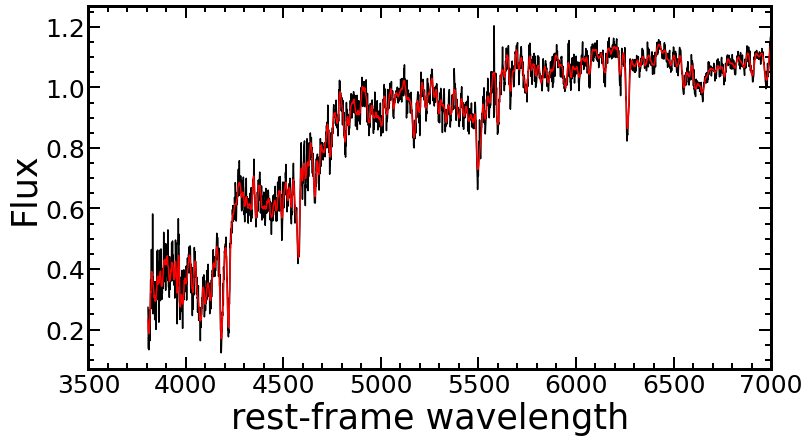

In [20]:
## Define the page
fig, axs = plt.subplots(1, 1, figsize=(12, 6))
fig.subplots_adjust(left=LM, right=RM, bottom=BM, top=TM) 

axs.set_xlabel('rest-frame wavelength')
axs.set_ylabel('Flux')
axs.set_xlim(3500., 7000.)

## Define Axes Styles
axs.plot(wave, nflux, c='k')
axs.plot(wave, sflux, c='r')

Let's run the pPXF to derive the velocity dispersions 

In [22]:
## Define pPXF models
sps_name = 'emiles' # 'fsps', 'galaxev', 'xsl' - choose the model you want

ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"

filename = ppxf_dir / 'sps_models' / basename
wave_range_temp = [3500., 10000.]


# Manipulate the spectrum and wavelengths
dlnwave  = (lnwave[-1] - lnwave[0]) / (lnwave.size - 1)   # Compute the Delta Lambda / Use full lam range for accuracy
velscale = c * dlnwave                                    # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)
noise    = np.full_like(nflux, 0.0166)                    # Assume constant noise per pixel here - JS, where does this 0.0166 comes from?

dwave    = np.gradient(wave)
wdisp    = spedata['wdisp']                              # Intrinsic dispersion of every pixel, in pixels units, wavelength dispersion in pixel=dloglam units
fwhm     = 2.3555 * wdisp * dwave

## Shift toward the rest-frame
wave_res = wave / (1. + spez) # _res stands for rest-frame
fwhm_res = fwhm / (1. + spez)  

# Construct the SPS model 
fwhm_gal   = {"lam" : wave_res, "fwhm": fwhm_res}
sps        = lib.sps_lib(filename, velscale, fwhm_gal, wave_range=wave_range_temp)
goodpixels = util.determine_goodpixels(np.log(wave_res), wave_range_temp)

wdisp [1.1981544  1.1979598  1.1977655  ... 0.81528556 0.81565243 0.8160197 ]
Elapsed time in pPXF: 1.36 s
[5.49423387e+01 2.00595279e+02 1.23194466e-03 3.63705338e-02]


In [26]:
# Actual pPXF fitting
vel        = 0.          # Since we already shifted to the rest-frame
start      = [vel, 200.] # (km/s), starting guess for [V, sigma]
time       = clock()   
#print(redshift, np.min(lam_gal), np.max(lam_gal), len(galaxy), len(sps.templates))

# Run pPXF
pp = ppxf(sps.templates, nflux, noise, velscale, start,
          goodpixels=goodpixels, plot=False, moments=4, trig=1,
          degree=20, lam=wave_res, lam_temp=sps.lam_temp, quiet=False)

print('Elapsed time in pPXF: %.2f s' % (clock() - time))
print(pp.sol)

errors = pp.error*np.sqrt(pp.chi2)  # Assume the fit is good chi2/DOF=1
redshift_fit = (1 + spez)*np.exp(pp.sol[0]/c) - 1     # eq. (5c) C23
redshift_err = (1 + redshift_fit)*errors[0]/c               # eq. (5d) C23

print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in errors))
prec = int(1 - np.floor(np.log10(redshift_err)))  # two digits of uncertainty
print(f"Best-fitting redshift z = {redshift_fit:#.{prec}f} "
        f"+/- {redshift_err:#.{prec}f}")

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:        55       201     0.001     0.036
chi2/DOF: 3.235; DOF: 3595; degree = 20; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
Elapsed time in pPXF: 1.51 s
[5.49423387e+01 2.00595279e+02 1.23194466e-03 3.63705338e-02]
Formal errors:
     dV    dsigma   dh3      dh4
     4.4     5.6   0.018    0.02
Best-fitting redshift z = 0.062995 +/- 0.000015


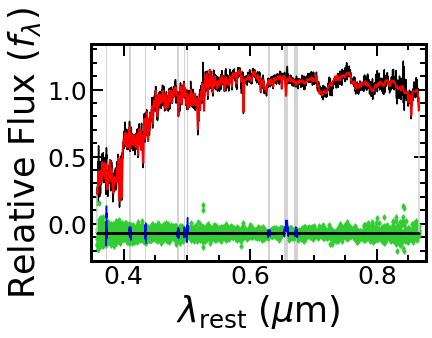

In [28]:
# Plot the fitting result
pp.plot()

Let's try to analyze spectral lines

0.1007719859480857
Emission lines included in gas templates:
['H10' 'H9' 'H8' 'Heps' 'Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[OII]3726'
 '[OII]3729' '[SII]6716' '[SII]6731' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
 Best Fit:       Vel     sigma
 comp.  0:     28908       104
 comp.  1:     28866       106
 comp.  2:     28866       112
Stars Attenuation A_V: 0.688
  Gas Attenuation A_V: 0.000
chi2/DOF: 110.3; DOF: 3814; degree = -1; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 38; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/169
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                   H10      0.000     0.045   28866   106
Comp:  1                    H9      0.000     0.045   28866   106
Comp:  1                    H8     0.3434     0.045   2886

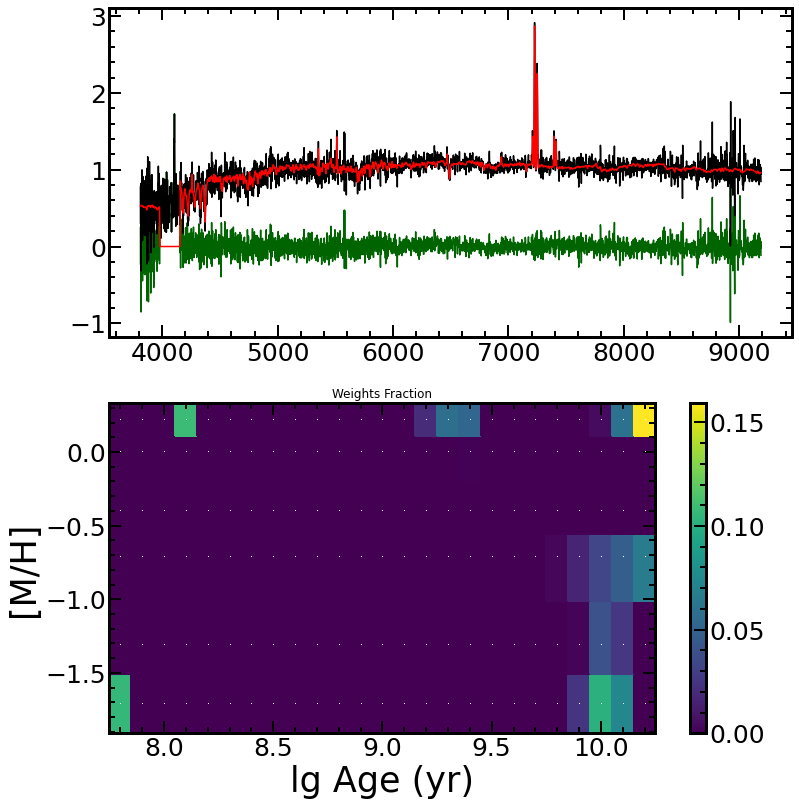

In [30]:
# Run pPXF for the single object : absorption line object

## Define the spectrum
spe1      = fits.open(spedir + 'spec-1938-53379-0284.fits')
spedata1  = spe1[1].data
spehdr1   = spe1[1].header
spez1     = 0.1007719859480857
print(spez1)

nflux1    = spedata1['flux'] / np.median(spedata1['flux']) # Normalize spectrum to avoid numerical issues
#sflux    = savgol_filter(nflux, window_length, polyorder) # Smoothed spectrum

lnwave1   = spedata1['loglam'] * np.log(10.)               # Convert lg --> ln
wave1     = np.exp(lnwave1)                                 # Wavelength in Angstroms

dlnwave1  = (lnwave1[-1] - lnwave1[0]) / (lnwave1.size - 1)   # Use full lam range for accuracy
velscale1 = c * dlnwave1                                    # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)
noise1    = np.full_like(nflux1, 0.0166)                    # Assume constant noise per pixel here - JS, where does this 0.0166 comes from?
fwhm1     = 2.76

## Setup the stellar template
sps = lib.sps_lib(filename, velscale1, fwhm1, norm_range=[5070, 5950])
reg_dim1 = sps.templates.shape[1:]
stars_templates1 = sps.templates.reshape(sps.templates.shape[0], -1)
regul_err1 = 0.1

## Setup the gas emission lines template
lam_range_gal1 = np.array([np.min(wave1), np.max(wave1)])/(1 + spez1)
gas_templates1, gas_names1, line_wave1 = util.emission_lines(sps.ln_lam_temp, lam_range_gal1, fwhm1)
templates1     = np.column_stack([stars_templates1, gas_templates1])

## Input parameters for pPXF
vel1 = c * np.log(1. + spez1)
start1 = [vel1, 180.]

n_temps1     = stars_templates1.shape[1]
n_forbidden1 = np.sum(["[" in a for a in gas_names1])  # forbidden lines contain "[*]"
n_balmer1    = len(gas_names1) - n_forbidden1

component1     = [0]*n_temps1 + [1]*n_balmer1 + [2]*n_forbidden1
gas_component1 = np.array(component1) > 0  # gas_component=True for gas templates

moments = [2, 2, 2]

start1 = [start1, start1, start1]

## Run the pPXF
t1 = clock()
pp = ppxf(templates1, nflux1, noise1, velscale1, start1,
          moments=moments, degree=-1, mdegree=-1, lam=wave1, lam_temp=sps.lam_temp,
          regul=1/regul_err1, reg_dim=reg_dim1, component=component1, gas_component=gas_component1,
          gas_names=gas_names1, reddening=0, gas_reddening=0)
print('Elapsed time in PPXF: %.2f s' % (clock() - t1))

weights1 = pp.weights[~gas_component1]
weights1 = weights1.reshape(reg_dim1)/weights1.sum()

sps.mean_age_metal(weights1)
sps.mass_to_light(weights1, band='SDSS/r', redshift=spez1)

## Define pages
fig, axs = plt.subplots(2, figsize=(12, 12))
fig.subplots_adjust(left=LM, right=RM, bottom=BM, top=TM) 

## Define Axes Styles
axs[0].plot(wave1, nflux1, c='k', zorder=2)
axs[0].plot(wave1, pp.bestfit, c='r', zorder=3)
axs[0].plot(wave1, (nflux1 - pp.bestfit), c='darkgreen', zorder=1)
#axs[0].plot(wave1, pp.goodpixels, c='magenta')

axs[1] = sps.plot(weights1)

Further Tutorial
https://github.com/micappe/ppxf_examples/tree/main

HW #1 
Let's try to run the pPXF to compute the redshifts and velocity dispersions 
for the remaining F2 galaxies 

Compare your results with the Portsmouth measurements. 